In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


#Import statements

In [2]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plots
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import io
import os
import random
from google.colab import files
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input, Dropout, RandomFlip, RandomRotation, Resizing, Rescaling
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC, binary_accuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers  import L2, L1
from tensorboard.plugins.hparams import api as hp
from google.colab import drive

#Data Preparation

# Data Loading

In [42]:
dataset, dataset_info = tfds.load('malaria', with_info=True,
                                  as_supervised=True,
                                  shuffle_files = True,
                                  split=['train'])

In [4]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir=PosixGPath('/tmp/tmpzduhnsqetfds'),
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear images},


In [43]:
for data in dataset[0].take(1):
  print(data)

(<tf.Tensor: shape=(151, 115, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)


In [ ]:
# for i in dataset.take(1):
#   print(i)

In [44]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)

  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

  val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

  test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))
  return train_dataset, val_dataset, test_dataset

In [45]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO )
#print(list(train_dataset.take(1).as_numpy_iterator()),
 #     list(val_dataset.take(1).as_numpy_iterator()), list(test_dataset.take(1).as_numpy_iterator()))

In [46]:
train_dataset

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

#Dataset Visualization

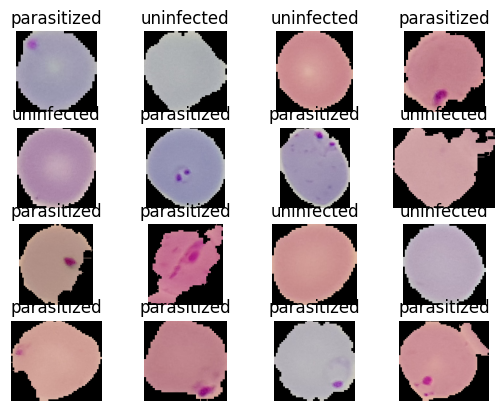

In [47]:
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 4, i + 1)

  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

In [48]:
dataset_info.features['label'].int2str(1)

'uninfected'

#Data Preprocessing

In [49]:
IM_SIZE = 224
def resize_rescale(image, label):
  return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0, label


In [50]:
train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)

In [51]:
train_dataset

<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [52]:
val_dataset

<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [53]:
test_dataset

<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [54]:
for image, label in train_dataset.take(1):
  print(image, label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(1, shape=(), dtype=int64)


In [55]:
BATCH_SIZE = 32

train_dataset = train_dataset.shuffle(
    buffer_size = 8,
    reshuffle_each_iteration = True,
).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [56]:

val_dataset = val_dataset.shuffle(
    buffer_size = 8,
    reshuffle_each_iteration = True,
).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [57]:

test_dataset = test_dataset.shuffle(
    buffer_size = 8,
    reshuffle_each_iteration = True,
).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

#Model Creation

In [20]:
lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3,)),

    Conv2D(filters = 6, kernel_size=3, strides= 1, padding='valid', activation='sigmoid'),
    BatchNormalization(),
    MaxPool2D (pool_size = 2, strides= 2),

    Conv2D(filters = 16, kernel_size= 3, strides= 1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D (pool_size = 2, strides= 2),

    Flatten(),


    Dense(1000, activation = "relu"),
    BatchNormalization(),

    Dense(100, activation = "relu"),
    BatchNormalization(),

    Dense(1, activation = "sigmoid"),
])

lenet_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                        

In [ ]:
# tf.keras.layers.Conv2D(
#     filters, kernel_size, strides=(1, 1), padding='valid',
#     data_format=None, dilation_rate=(1, 1), groups=1, activation=None,
#     use_bias=True, kernel_initializer='glorot_uniform',
#     bias_initializer='zeros', kernel_regularizer=None,
#     bias_regularizer=None, activity_regularizer=None, kernel_constraint=None,
#     bias_constraint=None, **kwargs
# )

In [21]:
lenet_model.compile(optimizer=Adam(learning_rate=0.01), loss=BinaryCrossentropy(),
                    metrics='accuracy')

In [22]:
history = lenet_model.fit(train_dataset, validation_data=val_dataset, epochs=20, verbose = 1)

Epoch 1/20
689/689 [==============================] - 90s 113ms/step - loss: 0.3223 - accuracy: 0.8701 - val_loss: 0.5593 - val_accuracy: 0.8156
Epoch 2/20
689/689 [==============================] - 51s 73ms/step - loss: 0.2012 - accuracy: 0.9325 - val_loss: 0.3017 - val_accuracy: 0.8944
Epoch 3/20
689/689 [==============================] - 49s 71ms/step - loss: 0.3710 - accuracy: 0.8270 - val_loss: 0.6668 - val_accuracy: 0.6025
Epoch 4/20
689/689 [==============================] - 50s 72ms/step - loss: 0.4408 - accuracy: 0.7922 - val_loss: 0.3079 - val_accuracy: 0.9143
Epoch 5/20
689/689 [==============================] - 48s 70ms/step - loss: 0.2114 - accuracy: 0.9242 - val_loss: 0.2086 - val_accuracy: 0.9387
Epoch 6/20
689/689 [==============================] - 50s 72ms/step - loss: 0.1931 - accuracy: 0.9334 - val_loss: 0.9197 - val_accuracy: 0.8759
Epoch 7/20
689/689 [==============================] - 48s 70ms/step - loss: 0.1908 - accuracy: 0.9348 - val_loss: 0.2030 - val_accuracy

# Visualisation of model training metrics

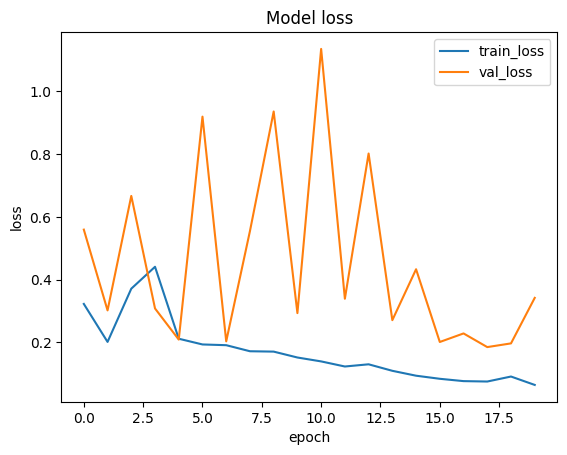

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

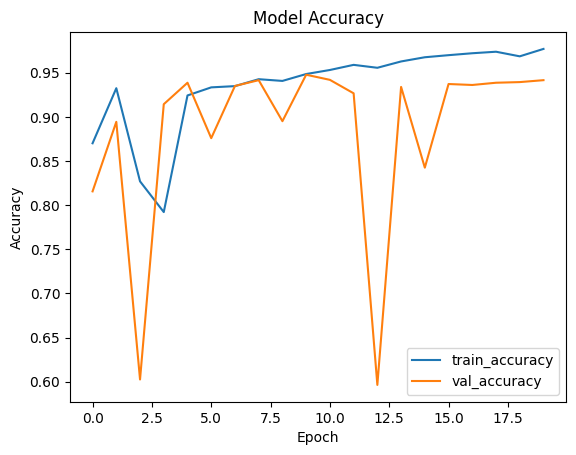

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

#Model Evaluation and Testing

In [58]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [59]:
test_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [60]:
test_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [27]:
lenet_model.evaluate(test_dataset)

87/87 [==============================] - 16s 46ms/step - loss: 0.3532 - accuracy: 0.9336


[0.35320016741752625, 0.9336234927177429]

In [29]:
# Saving model
lenet_model.save("/content/drive/My Drive/ML-with-tensorflow/Malaria detection/malaria_detection.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [69]:
lenet_model.load_weights("weights/lenet_weights")
lenet_model.evaluate(test_dataset)

NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for weights/lenet_weights

In [30]:
# test_dataset = test_dataset.batch(1)

In [61]:
lenet_model.predict(test_dataset.take(1))[0][0]

1/1 [==============================] - 12s 12s/step


6.0777566e-05

In [65]:
def parasite_or_not(x):
  if(x<0.5):
    return str('P')
  else:
    return str('U')

In [ ]:
# P=0 Unin = 1

In [66]:
parasite_or_not(lenet_model.predict(test_dataset.take(1))[0][0])

1/1 [==============================] - 11s 11s/step


'U'

In [67]:
def parasite_or_not(x):
  if(x<0.5):
    return str('P')
  else:
    return str('U')

parasite_or_not(lenet_model.predict(test_dataset.take(1))[0][0])


1/1 [==============================] - 12s 12s/step


'U'

1/1 [==============================] - 0s 37ms/step


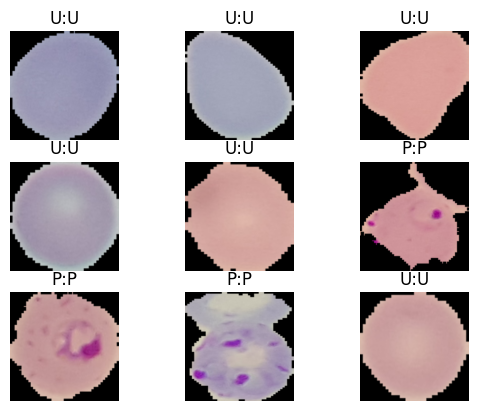

In [68]:
for i, (image, label) in enumerate(test_dataset.take(9)):

  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0])) + ":" + str(parasite_or_not(lenet_model.predict(image)[0][0])))

  plt.axis('off')

In [ ]:
# Loading and saving

In [ ]:
lenet_model.save("LenetSavedModel")

In [ ]:
# Saving model
lenet_model.save("/content/drive/My Drive/ML-with-tensorflow/Malaria detection/malaria_detection.h5")

In [ ]:
lenet_loaded_model = tf.keras.models.load_model("lenets")
lenet_loaded_model.summary()

In [ ]:
lenet_model.save("lenet.hdf5")

In [ ]:
lenet_loaded_model = tf.keras.models.load_model("lenet.hdf5")
lenet_loaded_model.summary()

In [ ]:
lenet_model.save_weights("weights/lenet_weights")

In [ ]:
lenet_weights_model = lenet_model.load_weights("weights/lenet_weights")

#Saving to Google drive

In [ ]:
drive.mount('/content/drive/')

In [ ]:
!cp -r /content/lenet/ /content/drive/MyDrive/lenet_colab/

In [ ]:
!cp -r /content/drive/MyDrive/lenet_colab/ /content/lenet_colab/

In [ ]:
image_1 = cv2.resize(cv2.imread('car.jpg'), (2560, 1440))/255
image_2 = cv2.resize(cv2.imread('train.jpg'), (2560, 1440))/255
print(image_1.shape, image_2.shape)

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(100, 100), dpi=80)

lamda = 0.6
image = lamda*image_1 + (1-lamda)*image_2

plt.imshow(image)
plt.axis('off')
plt.savefig('image.jpg')